In [62]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import numpy as np
import math

In [63]:
df = pd.read_csv('trade_1988_2021.csv')
df.dropna(inplace=True)
df.head()

,ReporterISO3,ReporterName,PartnerISO3,PartnerName,Year,TradeFlowName,TradeValue in 1000 USD
0,AFG,Afghanistan,SWE,Sweden,2017,Export,86.752
1,AFG,Afghanistan,JOR,Jordan,2018,Export,2796.481
2,AFG,Afghanistan,JOR,Jordan,2017,Export,3100.187
3,AFG,Afghanistan,ITA,Italy,2018,Export,279.918
4,AFG,Afghanistan,ITA,Italy,2017,Export,416.642


In [64]:
def momment(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

In [65]:
for year in df['Year'].unique():
    dfyear = df[df['Year'] == year]
    dfyear[['ReporterISO3', 'PartnerISO3', 'TradeValue in 1000 USD']].to_csv(f'RedesAnos/{year}.txt', sep=' ', index=False, header=False)

In [66]:
G = nx.read_edgelist('RedesAnos/2020.txt',data=(("weight", float),))

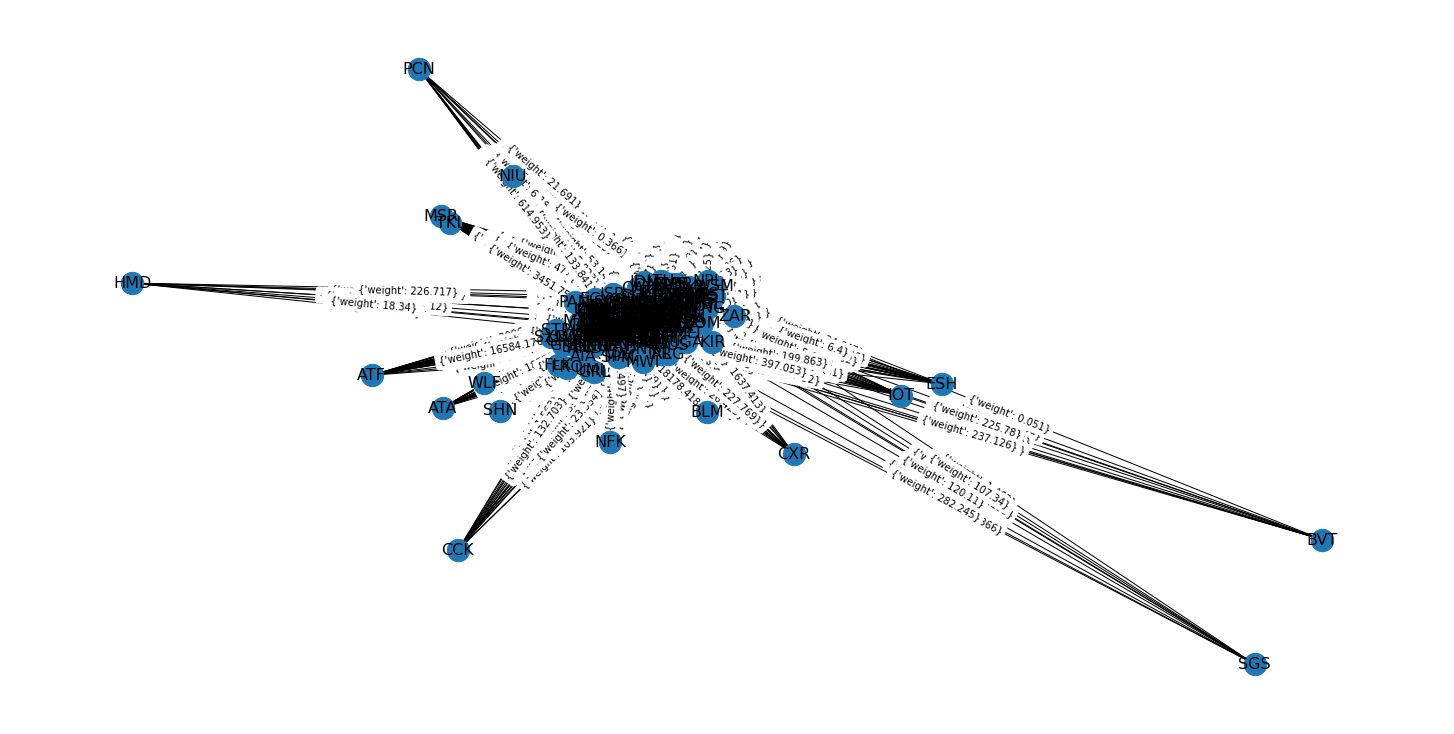

In [12]:
import matplotlib.pyplot as plt


pos=nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20, 10))
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
nx.draw_networkx_edge_labels(G, pos = pos)
plt.show()

In [92]:
weights = []
for year in np.sort(df['Year'].unique()):
    G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
    for (u,v,w) in G.edges(data=True):
        weights.append(w['weight'])


min_weight = np.median(weights)
print(np.median(weights))
print(min_weight)

# min_weight = 30000
G = nx.read_edgelist('RedesAnos/2020.txt',data=(("weight", float),))
Gnew = nx.Graph()
for (u,v,w) in G.edges(data=True):
    if w['weight'] > min_weight :
        Gnew.add_edge(u, v, weight=1)
G = Gnew

1871.0565
1871.0565


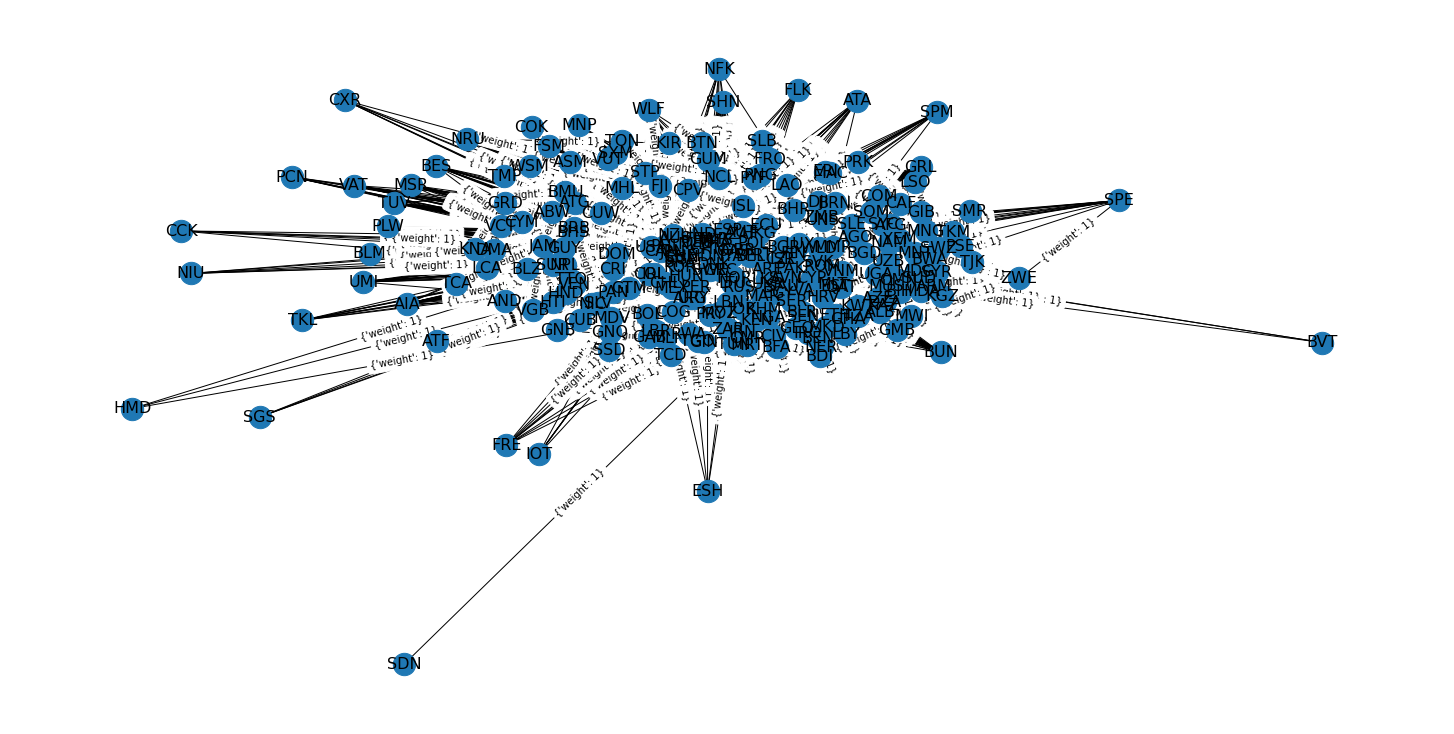

In [81]:
import matplotlib.pyplot as plt


pos=nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20, 10))
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
nx.draw_networkx_edge_labels(G, pos = pos)
plt.show()

Gerar redes para diversos anos e calcular medidas: average shortest path length,
entropia do grau, média do eigenvector centrality, modularidade etc.

In [93]:
result = pd.DataFrame(columns = ['Grau Medio', 'Entropia', 'Menor caminho medio', 'Eigenvector centrality', 'Assortatividade', 'Modularidade', 'Closeness centrality', 'Diametro', 'Eficiencia Global'])
medidas = []

for year in np.sort(df['Year'].unique()):
    G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))

    Gnew = nx.Graph()
    for (u,v,w) in G.edges(data=True):
        if w['weight'] > min_weight :
            Gnew.add_edge(u, v, weight=1)
    G = Gnew
    
    avg_dg = momment(G, 1)
    entropy = shannon_entropy(G)
    short_path = nx.average_shortest_path_length(G)
    eign_mean = np.mean(list(dict(nx.eigenvector_centrality(G)).values()))
    assortativity = nx.degree_assortativity_coefficient(G)

    lc = nx.community.louvain_communities(G)
    mod = nx.community.modularity(G, lc)
    
    close = np.mean(list(dict(nx.closeness_centrality(G)).values()))
    diameter = nx.diameter(G)
    ef = nx.global_efficiency(G)
    
    meds = [avg_dg, entropy, short_path, eign_mean, assortativity, mod, close, diameter, ef]
    
    result.loc[year] = meds

In [83]:
result.head(3)

,Grau Medio,Entropia,Menor caminho medio,Eigenvector centrality,Assortatividade,Modularidade,Closeness centrality,Diametro,Eficiencia Global
1988,37.231527,5.193548,1.827147,0.058028,-0.746612,0.071875,0.560582,3.0,0.590247
1989,48.321951,5.977134,1.777140,0.058580,-0.658479,0.085701,0.577825,3.0,0.616101
1990,53.736585,6.311106,1.746246,0.059193,-0.585646,0.086998,0.587744,3.0,0.630097


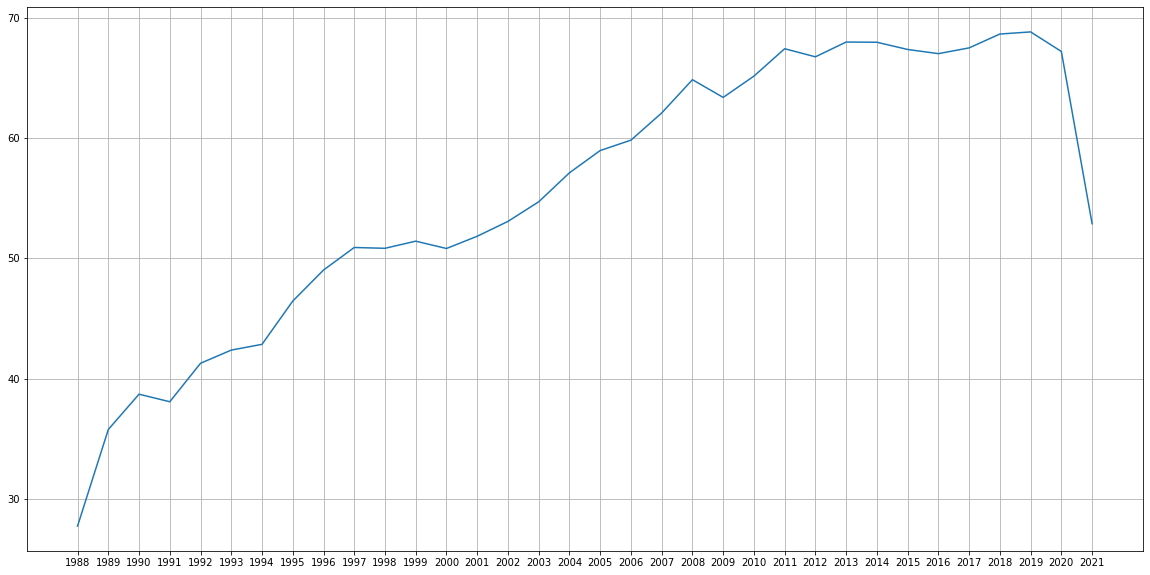

In [94]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.grid(True)
plt.plot(result['Grau Medio'])
plt.show()